In [1]:
import os
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.misc import imresize
import cv2

In [2]:
directory = 'words/'
images = [i for i in os.listdir(directory)]
labels = [os.path.splitext(i)[0] for i in images]
len(images)

24301

In [3]:
images[:5], labels[:5]

(['kuat.png', 'recak.png', 'durian.png', 'niagakan.png', 'lelampang.png'],
 ['kuat', 'recak', 'durian', 'niagakan', 'lelampang'])

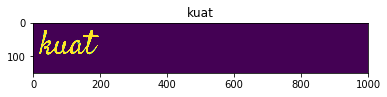

In [4]:
plt.imshow(cv2.imread(directory+images[0], 0).astype(np.float32)/255.)
plt.title(labels[0])
plt.show()

In [5]:
charset = list(set(''.join(labels)))
num_classes = len(charset) + 2
encode_maps = {}
decode_maps = {}
for i, char in enumerate(charset, 1):
    encode_maps[char] = i
    decode_maps[i] = char
    
SPACE_INDEX = 0
SPACE_TOKEN = '<PAD>'
encode_maps[SPACE_TOKEN] = SPACE_INDEX
decode_maps[SPACE_INDEX] = SPACE_TOKEN

In [6]:
[encode_maps[c] for c in labels[0]]

[10, 16, 21, 11]

In [7]:
image_height = 60
image_width = 180
image_channel = 1
max_stepsize = 64
num_hidden = 128
epoch = 20
batch_size = 32
initial_learning_rate = 1e-3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


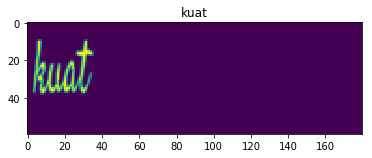

In [8]:
resized = imresize((cv2.imread(directory+images[0], 0).astype(np.float32)/255.), (image_height,
                                                                        image_width,
                                                                        image_channel))
plt.imshow(resized)
plt.title(labels[0])
plt.show()

In [9]:
import tqdm
X = []
for img in tqdm.tqdm(images):
    resized = imresize((cv2.imread(directory+img, 0).astype(np.float32)/255.), (image_height,
                                                                        image_width,
                                                                        image_channel))
    X.append(resized)

  0%|          | 0/24301 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
100%|██████████| 24301/24301 [01:08<00:00, 359.04it/s]


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
Y = []
for label in labels:
    Y.append([encode_maps[c] for c in label])

In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y)

In [13]:
len(train_X), len(test_X)

(18225, 6076)

In [14]:
def pad_second_dim(x, desired_size):
    padding = tf.tile([[0]], tf.stack([tf.shape(x)[0], desired_size - tf.shape(x)[1]], 0))
    return tf.concat([x, padding], 1)

class Model:
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [None, image_height, image_width, image_channel])
        self.Y = tf.sparse_placeholder(tf.int32)
        self.SEQ_LEN = tf.placeholder(tf.int32, [None])
        self.label = tf.placeholder(tf.int32, [None, None])
        self.Y_seq_len = tf.placeholder(tf.int32, [None])
        batch_size = tf.shape(self.X)[0]
        print(batch_size)
        filters = [64, 128, 128, max_stepsize]
        strides = [1, 2]
        x = self.conv2d(self.X, 'cnn-1', 3, 1, filters[0], strides[0])
        x = self.batch_norm('bn1', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-2', 3, filters[0], filters[1], strides[0])
        x = self.batch_norm('bn2', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-3', 3, filters[1], filters[2], strides[0])
        x = self.batch_norm('bn3', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = self.conv2d(x, 'cnn-4', 3, filters[2], filters[3], strides[0])
        x = self.batch_norm('bn4', x)
        x = self.leaky_relu(x, 0.01)
        x = self.max_pool(x, 2, strides[1])
        x = tf.reshape(x, [batch_size, -1, filters[3]])
        x = tf.transpose(x, [0, 2, 1])
        x = tf.reshape(x, [batch_size, filters[3], 48])
        cell = tf.contrib.rnn.LSTMCell(num_hidden)
        cell1 = tf.contrib.rnn.LSTMCell(num_hidden)
        stack = tf.contrib.rnn.MultiRNNCell([cell, cell1])
        outputs, _ = tf.nn.dynamic_rnn(stack, x, self.SEQ_LEN, dtype=tf.float32)
        outputs = tf.reshape(outputs, [-1, num_hidden])
        self.logits = tf.layers.dense(outputs, num_classes)
        shape = tf.shape(x)
        self.logits = tf.reshape(self.logits, [shape[0], -1, num_classes])
        self.logits = tf.transpose(self.logits, (1, 0, 2))
        self.global_step = tf.Variable(0, trainable=False)
        self.loss = tf.nn.ctc_loss(labels=self.Y,
                                   inputs=self.logits,
                                   sequence_length=self.SEQ_LEN)
        self.cost = tf.reduce_mean(self.loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=initial_learning_rate).minimize(self.cost)
        self.decoded, self.log_prob = tf.nn.ctc_beam_search_decoder(self.logits,
                                                                    self.SEQ_LEN,
                                                                    merge_repeated=False)
        decoded = tf.to_int32(self.decoded[0])
        self.dense_decoded = tf.sparse_tensor_to_dense(decoded)
        
        preds = self.dense_decoded[:, :tf.reduce_max(self.Y_seq_len)]
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        preds = pad_second_dim(preds, tf.reduce_max(self.Y_seq_len))
        y_t = tf.cast(preds, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(self.label, masks)
        self.mask_label = mask_label
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        
    def conv2d(self, x, name, filter_size, channel_in, channel_out, strides):
        with tf.variable_scope(name):
            return tf.layers.conv2d(x, channel_out, filter_size, strides, padding='SAME')
        
    
    def batch_norm(self, name, x):
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[-1]]
            beta = tf.get_variable('beta', params_shape, tf.float32,
                                   initializer=tf.constant_initializer(0.0, tf.float32))
            gamma = tf.get_variable('gamma', params_shape, tf.float32,
                                    initializer=tf.constant_initializer(1.0, tf.float32))
            mean, variance = tf.nn.moments(x, [0, 1, 2], name='moments')
            x_bn = tf.nn.batch_normalization(x, mean, variance, beta, gamma, 0.001)
            x_bn.set_shape(x.get_shape())
            return x_bn
        
    def leaky_relu(self, x, leak=0):
        return tf.where(tf.less(x, 0.0), leak * x, x, name='leaky_relu')
    
    def max_pool(self, x, size, strides):
        return tf.nn.max_pool(x, 
                              ksize=[1, size, size, 1],
                              strides=[1, strides, strides, 1],
                              padding='SAME',
                              name='max_pool')

In [15]:
def sparse_tuple_from_label(sequences, dtype=np.int32):
    indices, values = [], []
    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    return indices, values, shape


def pad_sentence_batch(sentence_batch, pad_int):
    padded_seqs = []
    seq_lens = []
    max_sentence_len = max([len(sentence) for sentence in sentence_batch])
    for sentence in sentence_batch:
        padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
        seq_lens.append(len(sentence))
    return padded_seqs, seq_lens

In [16]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model()
sess.run(tf.global_variables_initializer())

Tensor("strided_slice:0", shape=(), dtype=int32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [17]:
import time
from tqdm import tqdm

In [18]:
for e in range(epoch):
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'minibatch loop')
    total_lost, total_acc = 0, 0
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = train_Y[i : index]
        batch_y = sparse_tuple_from_label(y)
        batch_label, batch_length = pad_sentence_batch(y, 0)
        batch_len = np.asarray([max_stepsize for _ in [1]*len(batch_x)], dtype=np.int64)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len,
               model.label: batch_label,
               model.Y_seq_len: batch_length}
        accuracy, loss, _ = sess.run([model.accuracy,model.cost,model.optimizer],
                                    feed_dict = feed)
        total_lost += loss
        total_acc += accuracy
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    total_lost /= (len(train_X)/batch_size)
    total_acc /= (len(train_X)/batch_size)
    
    print('epoch %d, training avg loss %f, training avg acc %f'%(e+1,total_lost,total_acc))
    
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'minibatch loop')
    total_lost, total_acc = 0, 0
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = test_Y[i : index]
        batch_y = sparse_tuple_from_label(y)
        batch_label, batch_length = pad_sentence_batch(y, 0)
        batch_len = np.asarray([max_stepsize for _ in [1]*len(batch_x)], dtype=np.int64)
        feed = {model.X: batch_x,
                model.Y: batch_y,
                model.SEQ_LEN: batch_len,
               model.label: batch_label,
               model.Y_seq_len: batch_length}
        accuracy, loss = sess.run([model.accuracy,model.cost],
                                    feed_dict = feed)
        total_lost += loss
        total_acc += accuracy
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    total_lost /= (len(test_X)/batch_size)
    total_acc /= (len(test_X)/batch_size)
    
    print('epoch %d, testing avg loss %f, testing avg acc %f'%(e+1,total_lost,total_acc))

minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 1, training avg loss 19.789084, training avg acc 0.064299


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 1, testing avg loss 13.425713, testing avg acc 0.246836


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 2, training avg loss 9.028289, training avg acc 0.463775


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 2, testing avg loss 5.957848, testing avg acc 0.633889


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 3, training avg loss 4.519131, training avg acc 0.697247


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 3, testing avg loss 3.748554, testing avg acc 0.740846


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 4, training avg loss 2.962801, training avg acc 0.785586


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 4, testing avg loss 2.622751, testing avg acc 0.804624


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 5, training avg loss 2.150145, training avg acc 0.833433


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 5, testing avg loss 2.375447, testing avg acc 0.818894


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 6, training avg loss 1.660465, training avg acc 0.865160


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 6, testing avg loss 1.774771, testing avg acc 0.853771


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 7, training avg loss 1.317783, training avg acc 0.887648


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 7, testing avg loss 1.594641, testing avg acc 0.865021


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 8, training avg loss 1.131505, training avg acc 0.900833


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 8, testing avg loss 1.464068, testing avg acc 0.874039


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 9, training avg loss 0.976946, training avg acc 0.912274


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 9, testing avg loss 1.426495, testing avg acc 0.881239


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 10, training avg loss 0.838818, training avg acc 0.921934


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 10, testing avg loss 1.255062, testing avg acc 0.888256


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 11, training avg loss 0.706368, training avg acc 0.932893


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 11, testing avg loss 1.199969, testing avg acc 0.895740


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 12, training avg loss 0.635093, training avg acc 0.940652


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 12, testing avg loss 1.163361, testing avg acc 0.903659


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 13, training avg loss 0.577881, training avg acc 0.942031


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 13, testing avg loss 1.183215, testing avg acc 0.890470


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 14, training avg loss 0.490613, training avg acc 0.950228


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 14, testing avg loss 1.120939, testing avg acc 0.906923


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 15, training avg loss 0.443986, training avg acc 0.955645


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 15, testing avg loss 1.044668, testing avg acc 0.911303


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 16, training avg loss 0.399374, training avg acc 0.960159


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 16, testing avg loss 1.065574, testing avg acc 0.913293


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 17, training avg loss 0.372010, training avg acc 0.959865


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 17, testing avg loss 1.057484, testing avg acc 0.911164


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 18, training avg loss 0.325466, training avg acc 0.964301


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 18, testing avg loss 1.139331, testing avg acc 0.905505


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 19, training avg loss 0.284731, training avg acc 0.969491


minibatch loop:   0%|          | 0/570 [00:00<?, ?it/s]

epoch 19, testing avg loss 1.247893, testing avg acc 0.894815


minibatch loop:   0%|          | 0/190 [00:00<?, ?it/s]

epoch 20, training avg loss 0.285469, training avg acc 0.970238


minibatch loop: 100%|██████████| 190/190 [01:31<00:00,  2.14it/s, accuracy=0.86, cost=1.33]  

epoch 20, testing avg loss 1.077965, testing avg acc 0.912209


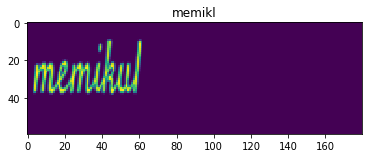

In [23]:
decoded = sess.run(model.dense_decoded, feed_dict = {model.X: batch_x[:1],
                                          model.SEQ_LEN: batch_len[:1]})
plt.imshow(batch_x[0][:,:,0])
plt.title(''.join([decode_maps[i] for i in decoded[0]]))
plt.show()